# Training Neural Networks to predict Scf

## Load Data
### Loading MODIS snow cover dataset

In [1]:
import xarray as xr
import geopandas as gpd
import rioxarray
import pandas as pd
from datetime import date
from matplotlib import pyplot as plt
import numpy as np
import pyproj
import pickle
import matplotlib.dates as mdates

In [2]:
import pandas as pd

# Define the path and filename for the dataset
data_file_path = 'Modis/'
data_filename = 'LebanonCSV.csv'

# Load the dataset into a dataframe
snow_cover_data = pd.read_csv(data_file_path + data_filename, index_col=0, decimal='.')

# Convert Day of Year (DOY) indices into datetime format for each year in the dataset
# Each column in the dataframe corresponds to a year, and the index values represent the day of the year
# The datetime conversion results in a matrix of dates corresponding to each year and day combination
date_matrix = pd.DataFrame(
    [pd.to_datetime(snow_cover_data.index - 1, unit='D', origin=str(year)) for year in snow_cover_data.columns]
).transpose()
date_matrix.index = snow_cover_data.index
date_matrix.columns = snow_cover_data.columns

# Convert the matrix structure into a single series by stacking
# This results in a series of dates and a series of snow cover fractions (scf)
dates_series = date_matrix.transpose().stack(dropna=False)
scf_series = snow_cover_data.transpose().stack(dropna=False)

# Combine the dates and scf series into a single dataframe
snow_cover_dataframe = pd.concat([dates_series, scf_series], axis=1, keys=['dates', 'snow_cover_fraction'])
snow_cover_dataframe.dropna(inplace=True)

# Adjust the datetime index to match the Uerra convention, which is 10h
snow_cover_dataframe.index = [date.replace(hour=10) for date in snow_cover_dataframe['dates']]

# Drop the dates column
snow_cover_dataframe.drop('dates', axis=1, inplace=True)

# Remove rows after the date 2022-07-31
cutoff_date = pd.Timestamp(2022, 7, 31, 10)
snow_cover_dataframe = snow_cover_dataframe[snow_cover_dataframe.index <= cutoff_date]


# Display the first 5 elements of the dataset
snow_cover_dataframe.head()

,snow_cover_fraction
2001-01-01 10:00:00,0.106
2001-01-02 10:00:00,0.106
2001-01-03 10:00:00,0.103
2001-01-04 10:00:00,0.096
2001-01-05 10:00:00,0.079


In [3]:
snow_cover_dataframe.tail()

,snow_cover_fraction
2022-07-26 10:00:00,0.0
2022-07-27 10:00:00,0.0
2022-07-28 10:00:00,0.0
2022-07-29 10:00:00,0.0
2022-07-30 10:00:00,0.0


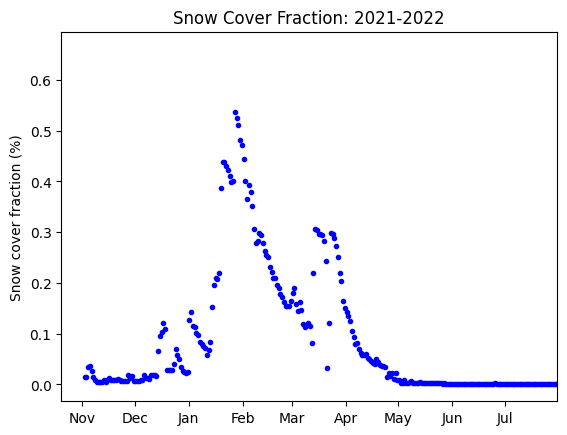

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date

# Extract observation dates and snow cover fractions from the dataframe
observation_dates = snow_cover_dataframe.index
snow_cover_fractions = snow_cover_dataframe['snow_cover_fraction']

# Plot snow cover fractions against observation dates
plt.plot(observation_dates, snow_cover_fractions, marker='.', linestyle='none', color='blue', label='Snow Cover Fraction')

# Set the x-axis limits
start_date = date(2021, 10, 20)
end_date = date(2022, 7, 31)
plt.xlim([start_date, end_date])

# Set the title and y-axis label
plt.title('Snow Cover Fraction: 2021-2022')
plt.ylabel('Snow cover fraction (%)')

# Configure x-axis to show months
current_axis = plt.gca()
current_axis.xaxis.set_major_locator(mdates.MonthLocator())
current_axis.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Display the plot
plt.show()

### Load UERRA snow depth data

Text(0.5, 1.0, 'Mean ERA-5 land snow depth')

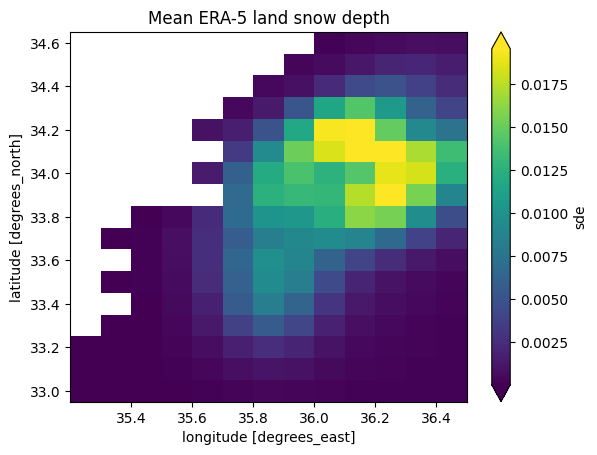

In [5]:
import xarray as xr

# Lazily load all HS netcdf from 2000 onward
snow_depth_dataframe = xr.open_mfdataset('DataExport/Lebanon-Snow-Cover-Data/*.nc')
#cropped_snow_depth_dataframe = snow_depth_dataframe.sel(latitude=slice(33,34.7,),longitude=slice(32,36.7))

# Map mean snow depth of the entire dataset
snow_depth_dataframe.sde.mean(dim='time').plot(robust=True)
plt.title('Mean ERA-5 land snow depth')

<Axes: >

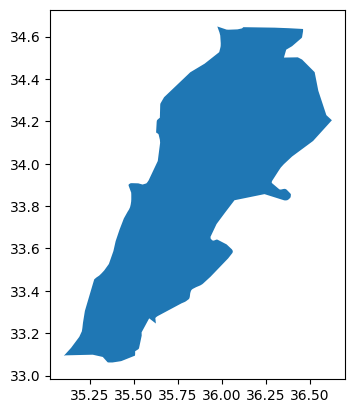

In [6]:
import geopandas as gpd

sf = gpd.read_file('shp/Lebanonshp/LebanonAoi.shp')
sf.plot()

Text(0.5, 1.0, 'Mean ERA5-land snow depth')

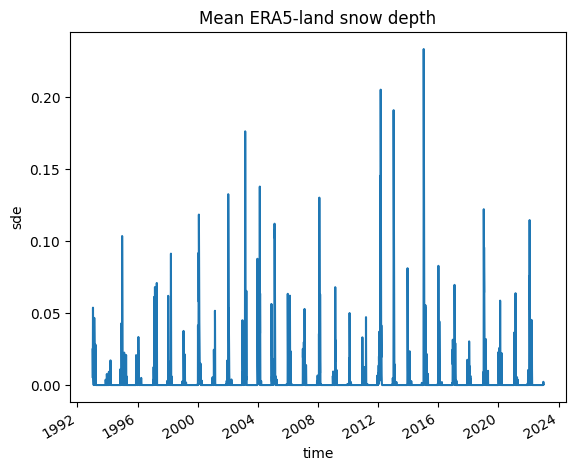

In [7]:
# plot mean snow depth
snow_depth_dataframe.sde.mean(dim=('longitude','latitude')).plot()
plt.title('Mean ERA5-land snow depth')

## Data Preparation
### Combine the two datasets

In [8]:
import numpy as np
# create datesSel vector containing matching dates from both datasets

datesSel = list(set(snow_cover_dataframe.index.values).intersection(snow_depth_dataframe.time.values))
datesSel.sort()
#print("Modis = " ,  Y.index.values)
#print("UERRA =", ds.time.values)
# reduce UERRA dataset to these dates
dsSel = snow_depth_dataframe.sel(time=datesSel)
# Make X array with predictors
X = dsSel['sde'].values.reshape(len(datesSel),-1)
# remove nodata [TODO: APPLY MODIS AOI MASK]
ix = np.all(np.isnan(X),axis=0)
# This is the array of training data (snow depth of every cell)
X = X[:,~ix]
# This is the array of target values (snow cover fraction)
y = snow_cover_dataframe.loc[datesSel].snow_cover_fraction

print('X dimensions:',X.shape)
print('y dimensions:',y.shape)

X dimensions: (5776, 168)
y dimensions: (5776,)


### Define the Nash criteria

In [9]:
def nash(y_true, y_pred):
    numerator = np.sum((y_true - y_pred) ** 2)
    denominator = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - numerator / denominator

### Data Exploration

In [10]:
y.head()

2001-01-01 10:00:00    0.106
2001-01-02 10:00:00    0.106
2001-01-03 10:00:00    0.103
2001-01-04 10:00:00    0.096
2001-01-05 10:00:00    0.079
Name: snow_cover_fraction, dtype: float64

In [11]:
y.describe()

count    5776.000000
mean        0.074575
std         0.111974
min         0.000000
25%         0.000000
50%         0.019500
75%         0.114000
max         0.662000
Name: snow_cover_fraction, dtype: float64

In [12]:
y.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 5776 entries, 2001-01-01 10:00:00 to 2022-07-30 10:00:00
Series name: snow_cover_fraction
Non-Null Count  Dtype  
--------------  -----  
5776 non-null   float64
dtypes: float64(1)
memory usage: 90.2 KB


In [13]:
y.isna().sum()

0

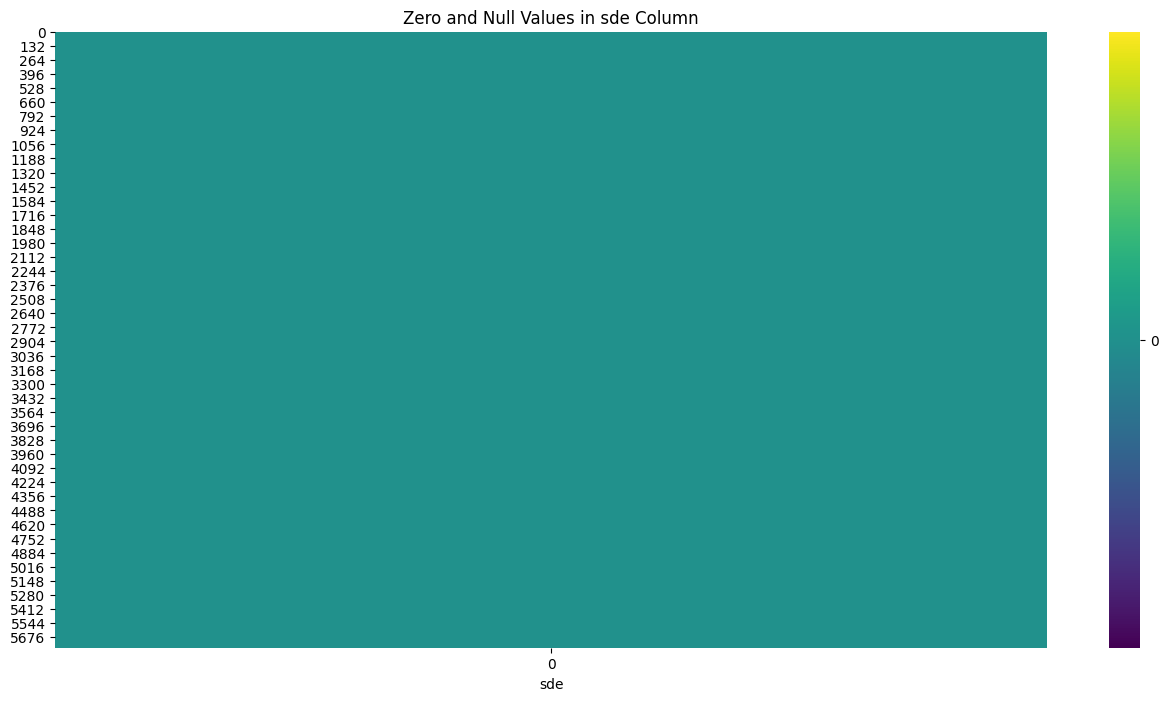

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a Series with the same shape as df.sde
combined_sde = pd.Series(index=y.index)

# Mark NaNs with 2
combined_sde[y.isna()] = 2

# Mark zeros with 1
combined_sde[y < 0] = 1

# Fill remaining spots with 0
combined_sde.fillna(0, inplace=True)

# Plot the heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(combined_sde.values.reshape(-1, 1), cbar=True, cmap='viridis', cbar_kws={'ticks': [0, 1, 2]})
plt.title('Zero and Null Values in sde Column')
plt.xlabel('sde')
plt.show()

In [15]:
print("Percentage of below 0 values in the dataset: {}%".format(round(((y.isna().sum() + (y < 0).sum())/y.shape[0])*100, 4)))

Percentage of below 0 values in the dataset: 0.0%


In [16]:
print("Percentage of 0 values in the dataset: {}%".format(round((((y == 0).sum())/y.shape[0])*100, 4)))

Percentage of 0 values in the dataset: 29.0339%


### Data Imputation

In [17]:
from sklearn.ensemble import RandomForestRegressor

def impute_with_rf_and_similar_days(series):
    imputed_series = series.copy()
    rf = RandomForestRegressor(n_estimators=100)
    global_mean = series.mean()  # Calculate the global mean to use for imputation if needed
    
    for idx, value in series.items():
        if pd.isnull(value):
            # Extract similar days (same day and month) from other years
            similar_dates = [date for date in series.index if date.month == idx.month and date.day == idx.day and date != idx]
            similar_values = series.loc[similar_dates]
            
            # If there are missing values on similar days, expand the window (e.g., +/- 1 day)
            if similar_values.isna().any():
                expanded_dates = [date for date in series.index if (0 <= (date - idx).days <= 1) and date != idx]
                similar_values = series.loc[expanded_dates]
            
            # Remove any NaNs in the similar values
            valid_similar_values = similar_values.dropna()

            # If there are enough samples to train the model
            if len(valid_similar_values) > 0:
                # Train the RandomForest using the years of the similar days as features
                X_train = np.array([date.year for date in valid_similar_values.index]).reshape(-1, 1)
                y_train = valid_similar_values.values
                rf.fit(X_train, y_train)
                
                # Predict the missing value using the year of the missing value as the feature
                X_pred = np.array([[idx.year]])
                imputed_value = rf.predict(X_pred)
                
                # Assign the predicted value
                imputed_series[idx] = imputed_value[0]
            else:
                # If there are no valid similar days, try interpolation
                imputed_series.interpolate(method='time', inplace=True)
                # If interpolation fails (edge cases), use global mean
                if pd.isnull(imputed_series[idx]):
                    imputed_series[idx] = global_mean
    
    return imputed_series

In [18]:
y_imputed = impute_with_rf_and_similar_days(y)

### Data Exploration Post Imputation

In [19]:
y_imputed.isna().sum()

0

In [20]:
y_imputed.to_frame()

,snow_cover_fraction
2001-01-01 10:00:00,0.106
2001-01-02 10:00:00,0.106
2001-01-03 10:00:00,0.103
2001-01-04 10:00:00,0.096
2001-01-05 10:00:00,0.079
...,...
2022-07-26 10:00:00,0.000
2022-07-27 10:00:00,0.000
2022-07-28 10:00:00,0.000
2022-07-29 10:00:00,0.000


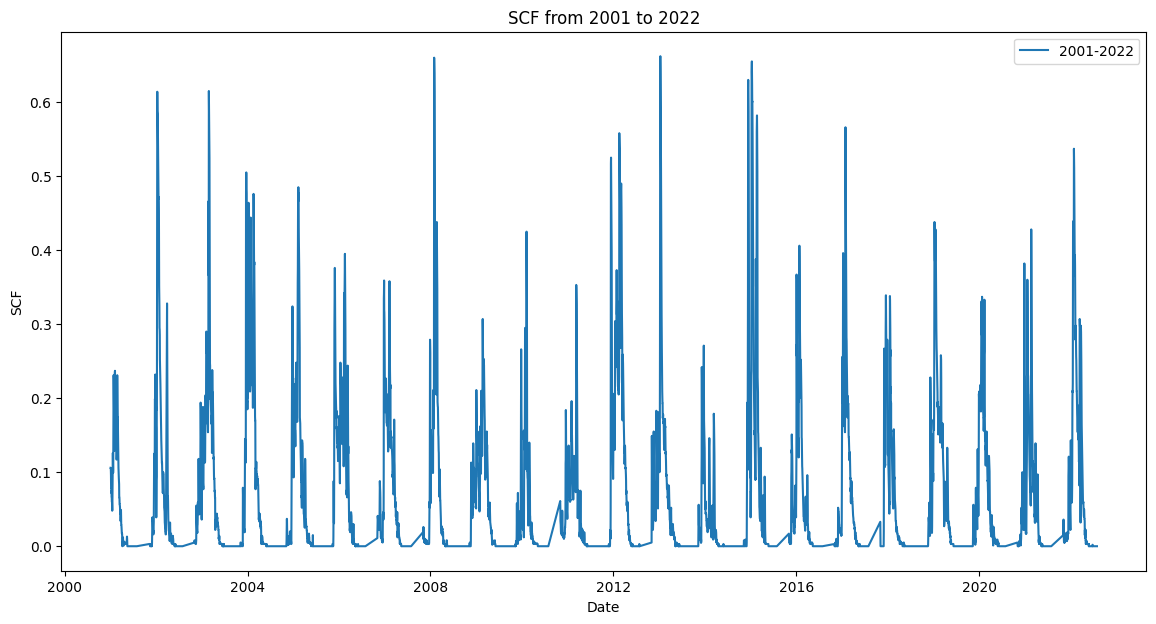

In [21]:
df = y_imputed.to_frame()
# Convert 'date' to datetime if it's not already
df['date'] = pd.to_datetime(df.index)


# Plotting
plt.figure(figsize=(14, 7))

# Plot the first period
plt.plot(df['date'], df['snow_cover_fraction'], label='2001-2022')

plt.xlabel('Date')
plt.ylabel('SCF')
plt.title('SCF from 2001 to 2022')
plt.legend()
plt.show()

In [22]:
df.isna().sum()

snow_cover_fraction    0
date                   0
dtype: int64

## Data Normalization and Splitting

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler(feature_range=(0, 1)).fit(X)
X_normalized = scaler_X.transform(X)


scaler_y = MinMaxScaler(feature_range=(0, 1)).fit(y_imputed.values.reshape(-1, 1))
y_normalized = scaler_y.transform(y_imputed.values.reshape(-1, 1)).flatten()

In [24]:
# Split data into training and validation sets
train_size = int(0.9 * len(X_normalized))
X_train, X_val = X_normalized[:train_size], X_normalized[train_size:]
y_train, y_val = y_normalized[:train_size], y_normalized[train_size:]  

## Build the predictive models

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam

# Assuming each year has 365 days (ignoring leap years for simplicity),
# we will use this as our sequence length.
sequence_length = 365

# Reshape the normalized scf values into sequences.
num_sequences = len(y_imputed.values.reshape(-1, 1)) // sequence_length
y_sequences = y_imputed.values.reshape(-1, 1)[:num_sequences * sequence_length].reshape(num_sequences, sequence_length, 1)

# For seq2seq, the input and output sequences are typically the same, but we can also offset them if needed.
X_train = y_sequences[:-1]  # Use all but the last sequence for training
y_train = y_sequences[1:]   # The next sequence is the target

# Define the LSTM seq2seq model architecture.
model = Sequential([
    LSTM(100, activation='relu', input_shape=(sequence_length, 1)),
    RepeatVector(sequence_length),
    LSTM(100, activation='relu', return_sequences=True),
    TimeDistributed(Dense(1))
])

# Compile the model with Adam optimizer and mean squared error loss function.
model.compile(optimizer=Adam(), loss='mse')

# Train the model.
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

# Save the model if needed.
# model.save('seq2seq_scf_model.h5')


2023-11-09 03:03:46.072743: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-09 03:03:46.074096: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-09 03:03:46.099574: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-09 03:03:46.099937: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-09 03:03:46.516879: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Epoch 1/100


2023-11-09 03:03:46.919950: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-09 03:03:46.920238: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


1/1 [==============================] - 1s 1s/step - loss: 0.0176 - val_loss: 0.0134
Epoch 2/100
1/1 [==============================] - 0s 112ms/step - loss: 0.0165 - val_loss: 0.0123
Epoch 3/100
1/1 [==============================] - 0s 106ms/step - loss: 0.0154 - val_loss: 0.0112
Epoch 4/100
1/1 [==============================] - 0s 112ms/step - loss: 0.0145 - val_loss: 0.0103
Epoch 5/100
1/1 [==============================] - 0s 107ms/step - loss: 0.0136 - val_loss: 0.0096
Epoch 6/100
1/1 [==============================] - 0s 109ms/step - loss: 0.0130 - val_loss: 0.0094
Epoch 7/100
1/1 [==============================] - 0s 109ms/step - loss: 0.0128 - val_loss: 0.0096
Epoch 8/100
1/1 [==============================] - 0s 101ms/step - loss: 0.0131 - val_loss: 0.0100
Epoch 9/100
1/1 [==============================] - 0s 103ms/step - loss: 0.0133 - val_loss: 0.0100
Epoch 10/100
1/1 [==============================] - 0s 107ms/step - loss: 0.0133 - val_loss: 0.0098
Epoch 11/100
1/1 [======

1/1 [==============================] - 0s 101ms/step - loss: 0.0124 - val_loss: 0.0093
Epoch 84/100
1/1 [==============================] - 0s 103ms/step - loss: 0.0124 - val_loss: 0.0093
Epoch 85/100
1/1 [==============================] - 0s 109ms/step - loss: 0.0124 - val_loss: 0.0093
Epoch 86/100
1/1 [==============================] - 0s 104ms/step - loss: 0.0124 - val_loss: 0.0093
Epoch 87/100
1/1 [==============================] - 0s 113ms/step - loss: 0.0124 - val_loss: 0.0093
Epoch 88/100
1/1 [==============================] - 0s 106ms/step - loss: 0.0123 - val_loss: 0.0093
Epoch 89/100
1/1 [==============================] - 0s 108ms/step - loss: 0.0123 - val_loss: 0.0093
Epoch 90/100
1/1 [==============================] - 0s 107ms/step - loss: 0.0123 - val_loss: 0.0093
Epoch 91/100
1/1 [==============================] - 0s 114ms/step - loss: 0.0123 - val_loss: 0.0093
Epoch 92/100
1/1 [==============================] - 0s 103ms/step - loss: 0.0123 - val_loss: 0.0093
Epoch 93/100


In [27]:
predictions = []

# Start with the last available sequence as the input for the first prediction.
current_sequence = y_sequences[-1].reshape(1, sequence_length, 1)

# Predict the next 10 years.
for _ in range(10):
    # Predict the next year.
    next_year_pred = model.predict(current_sequence)
    predictions.append(next_year_pred.flatten())

    # Update the current sequence to include the new prediction.
    current_sequence = np.roll(current_sequence, -1)
    current_sequence[0, -1, 0] = next_year_pred[0, -1, 0]

# Rescale the predictions back to the original scf scale.
# You will need to use the inverse_transform method of the scaler you used for normalization.
predictions_rescaled = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))

# Extend the original dataframe with the new predictions.
# You will need to create a new index for the predicted dates and then append the predictions to the dataframe.


1/1 [==============================] - 0s 23ms/step


In [28]:
np.array(predictions_rescaled).reshape(-1, 1)
predictions_rescaled.flatten()

array([0.01477487, 0.02160135, 0.02663465, ..., 0.02786949, 0.02786949,
       0.02786949], dtype=float32)

In [29]:
# Create a DataFrame for the forecasted values
forecast_dates = pd.date_range(start="2022-08-01", periods=3650, freq="D")
forecast_df = pd.DataFrame({
    "date": forecast_dates,
    "scf": predictions_rescaled.flatten()  # Use the flattened version of the rescaled predictions
})

# Assuming 'original_data' is the original dataset loaded into a DataFrame with 'date' and 'scf' columns
original_data = pd.DataFrame({"date": y.index, "scf": y.values})
extended_data = pd.concat([original_data, forecast_df], ignore_index=True)

# Check the extended DataFrame
print(extended_data.tail())  # Display the last few rows to verify the extension

           date       scf
9421 2032-07-24  0.027869
9422 2032-07-25  0.027869
9423 2032-07-26  0.027869
9424 2032-07-27  0.027869
9425 2032-07-28  0.027869


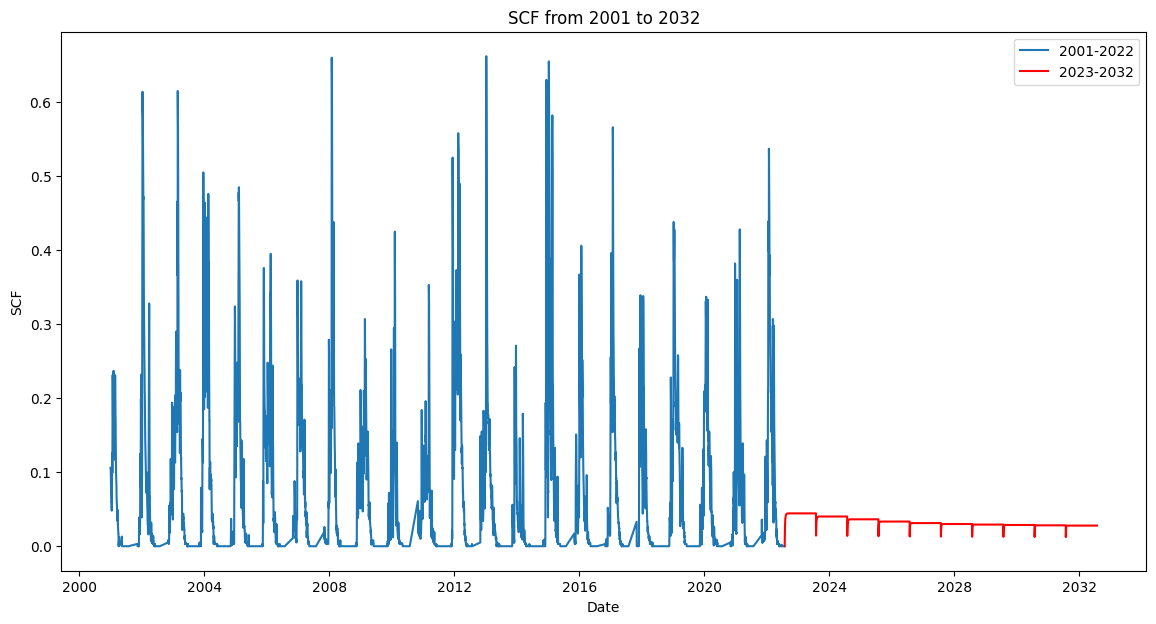

In [30]:
# Convert 'date' to datetime if it's not already
extended_data['date'] = pd.to_datetime(extended_data['date'])

# Set your cutoff date
cutoff_date = pd.to_datetime('2022-07-30')

# Split the data into two periods
data_before_cutoff = extended_data[extended_data['date'] <= cutoff_date]
data_after_cutoff = extended_data[extended_data['date'] > cutoff_date]

# Plotting
plt.figure(figsize=(14, 7))

# Plot the first period
plt.plot(data_before_cutoff['date'], data_before_cutoff['scf'], label='2001-2022')

# Plot the second period
plt.plot(data_after_cutoff['date'], data_after_cutoff['scf'], label='2023-2032', color='red')

plt.xlabel('Date')
plt.ylabel('SCF')
plt.title('SCF from 2001 to 2032')
plt.legend()
plt.show()

## Test SARIMA method 

In [25]:
import pandas as pd
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

df.set_index('date', inplace=True)
df = df.asfreq('D')  # Assume that we have daily frequency data

In [26]:
df.isna().sum()

snow_cover_fraction    2105
dtype: int64

In [27]:
df.index

DatetimeIndex(['2001-01-01 10:00:00', '2001-01-02 10:00:00',
               '2001-01-03 10:00:00', '2001-01-04 10:00:00',
               '2001-01-05 10:00:00', '2001-01-06 10:00:00',
               '2001-01-07 10:00:00', '2001-01-08 10:00:00',
               '2001-01-09 10:00:00', '2001-01-10 10:00:00',
               ...
               '2022-07-21 10:00:00', '2022-07-22 10:00:00',
               '2022-07-23 10:00:00', '2022-07-24 10:00:00',
               '2022-07-25 10:00:00', '2022-07-26 10:00:00',
               '2022-07-27 10:00:00', '2022-07-28 10:00:00',
               '2022-07-29 10:00:00', '2022-07-30 10:00:00'],
              dtype='datetime64[ns]', name='date', length=7881, freq='D')

In [28]:
df['snow_cover_fraction']

date
2001-01-01 10:00:00    0.106
2001-01-02 10:00:00    0.106
2001-01-03 10:00:00    0.103
2001-01-04 10:00:00    0.096
2001-01-05 10:00:00    0.079
                       ...  
2022-07-26 10:00:00    0.000
2022-07-27 10:00:00    0.000
2022-07-28 10:00:00    0.000
2022-07-29 10:00:00    0.000
2022-07-30 10:00:00    0.000
Freq: D, Name: snow_cover_fraction, Length: 7881, dtype: float64

In [29]:
imputed_series = impute_with_rf_and_similar_days(df['snow_cover_fraction'])

In [30]:
df['snow_cover_fraction'] = imputed_series

In [31]:
df.isna().sum()

snow_cover_fraction    0
dtype: int64

In [34]:
subset_df = df['snow_cover_fraction'].last('5Y')

# Use auto_arima to find the best SARIMAX parameters with a reduced search space
sarima_model = auto_arima(subset_df,
                          seasonal=True, 
                          m=365,  # Yearly seasonality
                          start_p=0, start_q=0,  # Starting values for p and q
                          max_p=1, max_q=1,  # Maximum p and q
                          start_P=0, start_Q=0,  # Starting values for P and Q
                          max_P=1, max_Q=1,  # Maximum P and Q
                          d=1,  # Fixed to avoid unnecessary differencing determination
                          D=1,  # Fixed assuming yearly seasonality requires one seasonal differencing
                          max_order=3,  # Limit the total number of parameters
                          trace=True, 
                          error_action='ignore',  
                          suppress_warnings=True,  
                          stepwise=False,  # Consider turning off stepwise for exhaustive search
                          n_jobs=-1,  # Use all available CPU cores
                          approximation=True)  # Use approximation for faster computation

# Summary of the best model
print(sarima_model.summary())


KeyboardInterrupt



In [33]:
# Assuming parameters for the SARIMA model
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 365)

# Fit the SARIMA model
model = SARIMAX(df['snow_cover_fraction'], order=order, seasonal_order=seasonal_order)

In [ ]:
model_fit = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.13107D+00    |proj g|=  1.16138D+01


 This problem is unconstrained.


In [ ]:
# Fit the SARIMA model with the identified parameters
# order = sarima_model.get_params()['order']
# seasonal_order = sarima_model.get_params()['seasonal_order']

# model = SARIMAX(df['snow_cover_fraction'], order=order, seasonal_order=seasonal_order)
# model_fit = model.fit()

# Forecast for the next 10 years
forecast_steps = 365 * 10  # Adjust if your data is not daily or to account for leap years
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_df = forecast.conf_int()
forecast_df['forecast'] = model_fit.predict(start=forecast_df.index[0], end=forecast_df.index[-1])

In [ ]:
# Plot the forecast alongside the original series
plt.figure(figsize=(14, 7))
plt.plot(df['snow_cover_fraction'], label='Observed')
plt.plot(forecast_df['forecast'], label='Forecast')
plt.fill_between(forecast_df.index, 
                 forecast_df.iloc[:, 0], 
                 forecast_df.iloc[:, 1], color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()